In [1]:
# import arnie
# import matplotlib.pyplot as plt
# from arnie.bpps import bpps
# import numpy as np
# import pandas as pd
# from pathlib import Path
# import os
# from tqdm import tqdm
# import torch
# import random
# def matrix_to_three_columns_np(bpp_matrix):
#     pos_1, pos_2 = np.nonzero(bpp_matrix)
#     probabilities = bpp_matrix[pos_1, pos_2]
#     result = np.column_stack((pos_1 + 1, pos_2 + 1, probabilities))
#     return result.astype('float16')

# def get_bpp(sequnce, package):
#     return bpps(sequnce, package=package)


# def save_bpp(row, save_dir, package):
#     name = save_dir/f"{row.sequence_id}.npy"
#     bpp = get_bpp(row.sequence, package)
#     np.save(name, matrix_to_three_columns_np(bpp))
    
# pkg_name = "contrafold_2" #"vienna_2" #
# path = Path('/mnt/e22b12fe-f946-49d6-be2c-4bd0bb62c767/slh/rna/eda/')
# save_dir = path/f'bpp/{pkg_name}/'
# os.makedirs(save_dir, exist_ok=True)
# df = pd.read_parquet(path/'train_ss_vienna_rna.parquet')[['sequence_id', 'sequence']]
# df

# for i in tqdm(range(df.shape[0])):
#     save_bpp(df.iloc[i], save_dir, pkg_name)

In [2]:
from PIL import Image
import random
from scipy.sparse import coo_matrix
import arnie
import matplotlib.pyplot as plt
from arnie.bpps import bpps
import numpy as np
import pandas as pd
from pathlib import Path
import os
from tqdm import tqdm
import torch
from joblib import Parallel, delayed
from scipy.io import mmwrite


/home/exx/.conda/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:


def matrix_to_three_columns_np(bpp_matrix):
    pos_1, pos_2 = np.nonzero(bpp_matrix)
    probabilities = bpp_matrix[pos_1, pos_2]
    # Create an empty structured array with desired data types for each column
    if bpp_matrix.shape[-1] > 255:
        dt = np.dtype([('pos_1', 'int'), ('pos_2', 'int'), ('probabilities', 'float16')])
    else:
        dt = np.dtype([('pos_1', 'uint8'), ('pos_2', 'uint8'), ('probabilities', 'float16')])
        
    result = np.zeros(len(pos_1), dtype=dt)
    # Fill the structured array with values
    result['pos_1'] = pos_1
    result['pos_2'] = pos_2 
    result['probabilities'] = probabilities
    return result

def get_bpp(sequnce, package):
    return bpps(sequnce, package=package)

def save_bpp(row, save_dir, package):
    name = save_dir/f"{row.sequence_id}.npy"
    try:
        bpp = get_bpp(row.sequence, package)
        np.save(name, matrix_to_three_columns_np(bpp))
    except:
        pass


names = []
def save_png(row, save_dir, package):
    name = save_dir/f"{row.sequence_id}.png"
    try:
        bpp = get_bpp(row.sequence, package)
        Image.fromarray((bpp* 255).astype('uint8')).save(name)
    except:
        names.append(name)
        
# def save_sparse(row, save_dir, package):
#     name = save_dir/f"{row.sequence_id}.mtx"
#     try:
#         bpp = get_bpp(row.sequence, package).astype('float16')
#         sparse = coo_matrix(bpp)
#         mmwrite(name, sparse)
#     except:
#         names.append(name)
        
    
# pkg_name = "contrafold_2" 
# path = Path('/mnt/e22b12fe-f946-49d6-be2c-4bd0bb62c767/slh/rna/eda/')
# save_dir = path/f'bpp/{pkg_name}/'
# os.makedirs(save_dir, exist_ok=True)
# df = pd.read_parquet(path/'test_ss_vienna_rna.parquet')[['sequence_id', 'sequence']]
# df["L"] = df['sequence'].map(len)
# df = df.query('L>250')
# df.sort_values(by='L',ascending=False, inplace=True)

# # Using joblib to parallelize the tasks
# results = Parallel(n_jobs=16)(delayed(save_bpp)(row, save_dir, pkg_name) for _, row in tqdm(df.iterrows(), total=df.shape[0]))
# print(names)

In [54]:
# #fns = list(save_dir.glob('*.npy'))
# import shutil
# pkg_name = "contrafold_2" 
# path = Path('/mnt/e22b12fe-f946-49d6-be2c-4bd0bb62c767/slh/rna/eda/')
# save_dir = path/f'bpp/{pkg_name}/'
# fns = [save_dir/f"{i}.npy" for i in df['sequence_id'].to_list()]
# new_dir  = path/f'bpp/{pkg_name}_8000/'
# os.makedirs(new_dir, exist_ok=True)
# for fn in tqdm(fns):
#     shutil.copy(fn, new_dir)


  0%|          | 0/8000 [00:00<?, ?it/s]100%|██████████| 8000/8000 [00:01<00:00, 6075.23it/s]


In [55]:
# fns = list(new_dir.glob('*.npy'))

In [4]:
def load_and_convert(filename, N):
    """
    Load data from a .npy file and convert it to an N x N matrix.

    Parameters:
    - filename: Path to the .npy file.
    - N: Dimension of the square matrix.

    Returns:
    - bpp_matrix: N x N matrix reconstructed from the input file.
    """
    # Load the structured array from the .npy file
    data = np.load(filename)

    # Create an empty N x N matrix
    bpp_matrix = np.zeros((N, N))

    # Fill the matrix with the probabilities from the loaded data
    bpp_matrix[data['pos_1'], data['pos_2']] = data['probabilities']

    return bpp_matrix

In [16]:


    
pkg_name = "vienna_2" 
path = Path('/mnt/e22b12fe-f946-49d6-be2c-4bd0bb62c767/slh/rna/eda/')
save_dir = path/f'bpp/R1138v1_m2/{pkg_name}/'
os.makedirs(save_dir, exist_ok=True)
df =  pd.read_csv('../data/R1138v1_m2.csv')[['sequence_id', 'sequence']]
df["L"] = df['sequence'].map(len)
df.sort_values(by='L',ascending=False, inplace=True)

# Using joblib to parallelize the tasks
results = Parallel(n_jobs=8)(delayed(save_bpp)(row, save_dir, pkg_name) for _, row in tqdm(df.iterrows(), total=df.shape[0]))
print(names)

100%|██████████| 721/721 [01:33<00:00,  7.69it/s]


[]


In [17]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

fns = list(save_dir.rglob('*.npy'))
print(len(fns))

721


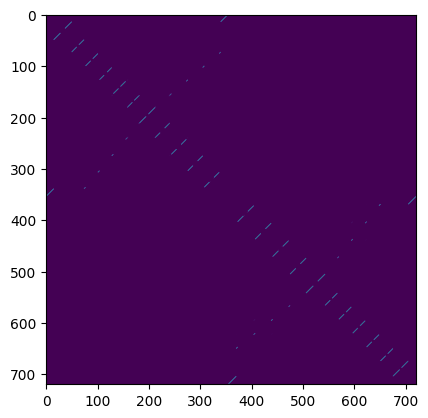

In [19]:
plt.imshow(load_and_convert(random.choice(fns), 720))

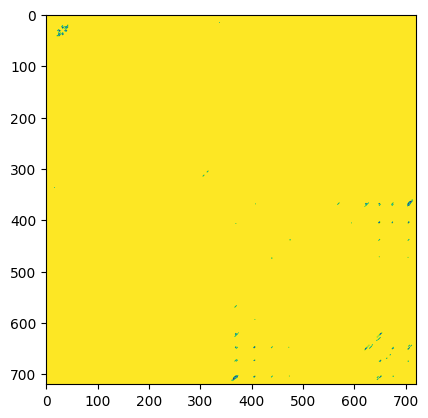

In [25]:
plt.imshow(load_and_convert(random.choice(fns), 720) == load_and_convert(random.choice(fns), 720))